# MaskFormer: 基于 Transformer 的图像分割

MaskFormer [Hugging Face transformers 文档](https://huggingface.co/docs/transformers/en/model_doc/maskformer)) 在论文[MaskFormer: Per-Pixel Classification is Not All You Need for Semantic Segmentation](https://arxiv.org/abs/2107.06278) 中提出，是一种为图像中每个类预测分割掩码的模型，将语义分割和实例分割统一在一个架构中。

## CNN 与 Transformer 在分割任务中的对比

在 Vision Transformers 出现之前，卷积神经网络 (CNN) 是图像分割的首选。例如，[U-Net](https://arxiv.org/abs/1505.04597) 和 [Mask R-CNN](https://arxiv.org/abs/1703.06870) 等模型能够捕捉区分图像中不同对象所需的细节，使其在分割任务中表现出色。

尽管 CNN 模型在过去十年中取得了优异的结果，但它们仍存在一些限制，Transformer 的出现则意在解决这些问题：

* 空间局限性：CNN 通过小的感受野学习局部模式，这种局部关注使它们难以“连接”图像中相隔较远但相关的特征，从而影响其准确分割复杂场景或对象的能力。与 CNN 不同，ViT 利用注意力机制设计用于捕捉图像中的全局依赖关系。这意味着基于 ViT 的模型能够一次性考虑整个图像，从而理解图像中远距离部分之间的复杂关系。对于分割任务，这种全局视角能够更准确地划分对象。
* 任务特定组件：如 Mask R-CNN 之类的方法包含手工设计的组件（如非最大值抑制、空间锚点）以编码有关分割任务的先验知识。这些组件增加了复杂性并需要手动调整。而基于 ViT 的分割方法通过消除手工设计的组件，简化了分割过程，更易于优化。

分割任务的专业化：基于 CNN 的分割模型分别处理语义、实例和全景分割任务，从而为每个任务设计了专门的架构，且每个任务都需要单独的研究。近期的基于 ViT 的模型如 [MaskFormer](https://arxiv.org/abs/2107.06278)、[SegFormer](https://arxiv.org/abs/2105.15203) 或 [SAM](https://arxiv.org/abs/2304.02643) 提供了一种统一的方法，在一个框架内处理语义、实例和全景分割任务。

## 模型架构


<div class="wy-nav-content-img">
    <img src="assets/MaskFormer_model_arch.png" width=800px alt="MaskFormer 的模型架构图">
    <p>图1：MaskFormer 的模型架构图</p>
</div>

该架构由以下三部分组成：

* 像素级模块：利用主干网络提取图像特征，并通过像素解码器生成每个像素的 embbeding，它的输出是一个 $\frac{H}{4} \times \frac{W}{4} \times 256$ 的 Tensor。
* Transformer 模块：使用标准 Transformer 解码器从图像特征和可学习的位置嵌入（查询）中计算每个分割的嵌入，编码每个分割的全局信息，模块输出的是一个 $100\times 256$ 的 Tensor，其中 100 代表 Query 数量，也就是图像中要分割的实体的个数。
* 分割模块：使用线性分类器和多层感知机 (MLP) 分别生成每个分割的类别概率预测和掩码嵌入。Mask Embedding 结合 Pixel Embeeding，用于预测每个分割的二进制掩码。

该模型使用与 DETR 相同的二进制掩码损失以及每个预测分割的交叉熵分类损失进行训练。

## MaskFormer的手动实现

<div class="wy-nav-content-img">
    <img src="assets/MaskFormer_model_inference.drawio.svg" width=1000px alt="MaskFormer 的推理过程注解">
    <p>图2：MaskFormer 的推理过程注解</p>
</div>


## 在 Transformers 中使用

### MaskFormerModel的使用

In [1]:
from transformers import AutoImageProcessor, MaskFormerModel
from PIL import Image
import requests

# load MaskFormer fine-tuned on ADE20k semantic segmentation
image_processor = AutoImageProcessor.from_pretrained(
    "facebook/maskformer-swin-base-ade"
)
model = MaskFormerModel.from_pretrained("facebook/maskformer-swin-base-ade")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = image_processor(image, return_tensors="pt")

# forward pass
outputs = model(**inputs)

# (batch_size, 256, W//4, H//4)
pixel_decoder_last_hidden_state = outputs.pixel_decoder_last_hidden_state

print(pixel_decoder_last_hidden_state.shape)
# the decoder of MaskFormer outputs hidden states of shape (batch_size, num_queries, hidden_size)
transformer_decoder_last_hidden_state = outputs.transformer_decoder_last_hidden_state
print(transformer_decoder_last_hidden_state.shape)

/home/yangyansheng/miniconda3/envs/pyml/lib/python3.10/site-packages/transformers/utils/deprecation.py:165: FutureWarning: `max_size` is deprecated and removed starting from version 4.27.0 for `MaskFormerImageProcessor.__init__`.
  return func(*args, **kwargs)


torch.Size([1, 256, 160, 216])
torch.Size([1, 100, 256])


In [2]:
from matplotlib import pyplot as plt


def show_image_comparison(image, predicted_map, segmentation_title):
    """并排显示原始图像和分割图像。

    Args:
        image (PIL.Image): 原始图像。
        predicted_map (PIL.Image): 分割图像。
        segmentation_title (str): 分割图像的标题。
    """

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_map)
    plt.title(segmentation_title + " Segmentation")
    plt.axis("off")
    plt.show()

### Semantic segmentation 

/home/yangyansheng/miniconda3/envs/pyml/lib/python3.10/site-packages/transformers/utils/deprecation.py:165: FutureWarning: `max_size` is deprecated and removed starting from version 4.27.0 for `MaskFormerImageProcessor.__init__`.
  return func(*args, **kwargs)


torch.Size([480, 640])


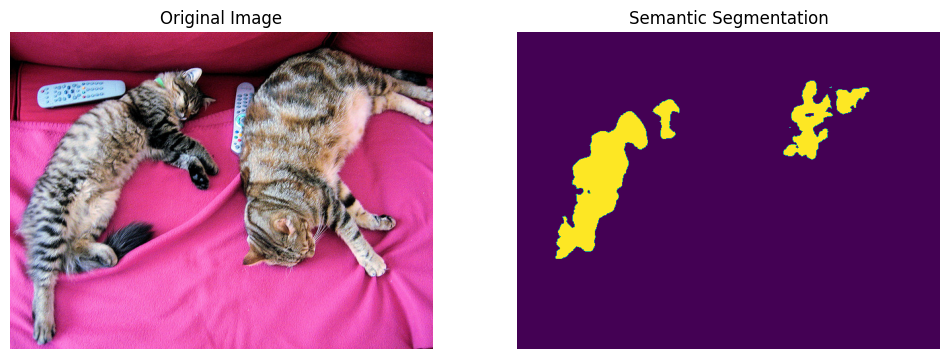

In [3]:
from transformers import AutoImageProcessor, MaskFormerForInstanceSegmentation
from PIL import Image
import requests


# load MaskFormer fine-tuned on ADE20k semantic segmentation
image_processor = AutoImageProcessor.from_pretrained(
    "facebook/maskformer-swin-base-ade"
)
model = MaskFormerForInstanceSegmentation.from_pretrained(
    "facebook/maskformer-swin-base-ade"
)

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
inputs = image_processor(images=image, return_tensors="pt")

outputs = model(**inputs)
# model predicts class_queries_logits of shape `(batch_size, num_queries)`
# and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits

# you can pass them to image_processor for postprocessing
predicted_semantic_map = image_processor.post_process_semantic_segmentation(
    outputs, target_sizes=[image.size[::-1]]
)[0]

# we refer to the demo notebooks for visualization (see "Resources" section in the MaskFormer docs)
print(predicted_semantic_map.shape)
show_image_comparison(image, predicted_semantic_map, "Semantic")

### Instance Segmentation

segmentation map shape:  torch.Size([480, 640])
[{'id': 0, 'label_id': 65, 'was_fused': False, 'score': 0.973134}, {'id': 1, 'label_id': 15, 'was_fused': False, 'score': 0.924365}, {'id': 2, 'label_id': 15, 'was_fused': False, 'score': 0.950401}, {'id': 3, 'label_id': 65, 'was_fused': False, 'score': 0.964203}, {'id': 4, 'label_id': 57, 'was_fused': False, 'score': 0.709845}]


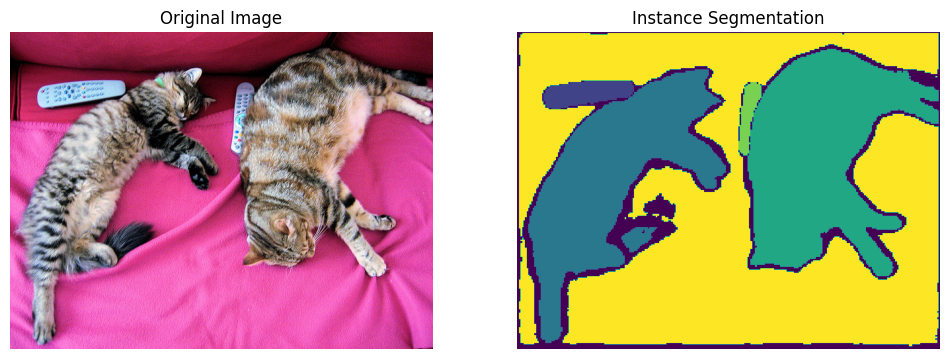

In [4]:
from transformers import AutoImageProcessor, MaskFormerForInstanceSegmentation
from PIL import Image
import requests

# load MaskFormer fine-tuned on COCO panoptic segmentation
image_processor = AutoImageProcessor.from_pretrained(
    "facebook/maskformer-swin-base-coco"
)
model = MaskFormerForInstanceSegmentation.from_pretrained(
    "facebook/maskformer-swin-base-coco"
)

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
inputs = image_processor(images=image, return_tensors="pt")

outputs = model(**inputs)
# model predicts class_queries_logits of shape `(batch_size, num_queries)`
# and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits

# you can pass them to image_processor for postprocessing
result = image_processor.post_process_instance_segmentation(
    outputs, target_sizes=[image.size[::-1]]
)[0]

# we refer to the demo notebooks for visualization (see "Resources" section in the MaskFormer docs)
predicted_instance_map = result["segmentation"]
print("segmentation map shape: ", predicted_instance_map.shape)
print(result["segments_info"])
show_image_comparison(image, predicted_instance_map, "Instance")

### Panoptic segmentation

`label_ids_to_fuse` unset. No instance will be fused.


segmentation map shape:  [{'id': 1, 'label_id': 57, 'was_fused': False, 'score': 0.839535}, {'id': 2, 'label_id': 65, 'was_fused': False, 'score': 0.993197}, {'id': 3, 'label_id': 81, 'was_fused': False, 'score': 0.622391}, {'id': 4, 'label_id': 15, 'was_fused': False, 'score': 0.997852}, {'id': 5, 'label_id': 65, 'was_fused': False, 'score': 0.998006}, {'id': 6, 'label_id': 15, 'was_fused': False, 'score': 0.997469}]


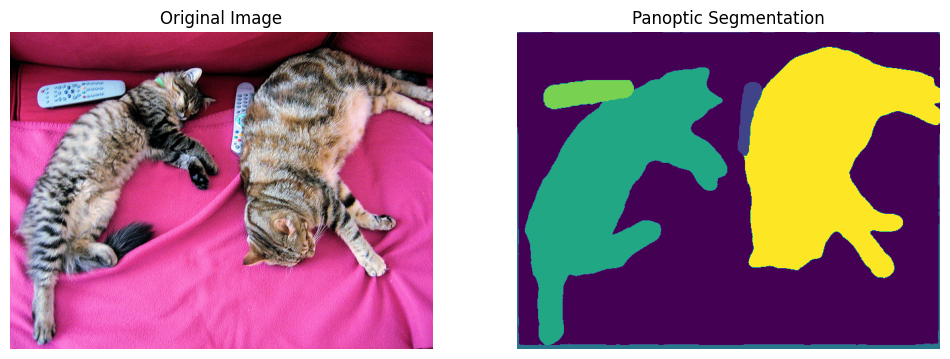

In [ ]:
from transformers import AutoImageProcessor, MaskFormerForInstanceSegmentation
from PIL import Image
import requests

# load MaskFormer fine-tuned on COCO panoptic segmentation
image_processor = AutoImageProcessor.from_pretrained(
    "facebook/maskformer-swin-base-coco"
)
model = MaskFormerForInstanceSegmentation.from_pretrained(
    "facebook/maskformer-swin-base-coco"
)

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
inputs = image_processor(images=image, return_tensors="pt")

outputs = model(**inputs)
# model predicts class_queries_logits of shape `(batch_size, num_queries)`
# and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits

# you can pass them to image_processor for postprocessing
result = image_processor.post_process_panoptic_segmentation(
    outputs, target_sizes=[image.size[::-1]]
)[0]

# we refer to the demo notebooks for visualization (see "Resources" section in the MaskFormer docs)
predicted_panoptic_map = result["segmentation"]
print("segmentation map shape: ", list(predicted_panoptic_map.shape))
print(result["segments_info"])
show_image_comparison(image, predicted_panoptic_map, "Panoptic")